# RL and Advanced DL: Домашнее задание 2

## Часть 2: добавим нейронных сетей

Студент Черников Дмитрий, ML-32

In [1]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import json
import math
import random
import numpy as np
import scipy as sp
import pandas as pd
import scipy.stats as st
import scipy.integrate as integrate
from scipy.stats import multivariate_normal
from sklearn import linear_model
from sklearn.utils._testing import ignore_warnings
from sklearn.exceptions import ConvergenceWarning
import statsmodels.api as sm
from matplotlib.colors import LogNorm
from IPython.display import clear_output
from tqdm import tqdm
import pickle
import copy

from joblib import Parallel, delayed
import multiprocessing
from collections import namedtuple, defaultdict, Counter, deque
from itertools import count

from tictactoe import TicTacToe

import cProfile
from datetime import datetime

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision.transforms as T
from torch.autograd import Variable

sns.set_style("whitegrid")
sns.set_palette("colorblind")
palette = sns.color_palette()
figsize = (15,8)
legend_fontsize = 16

from matplotlib import rc
rc('font',**{'family':'sans-serif'})
rc('text', usetex=True)
rc('text.latex',preamble=r'\usepackage[utf8]{inputenc}')
rc('text.latex',preamble=r'\usepackage[russian]{babel}')
rc('figure', **{'dpi': 300})

In [2]:
N_ROWS, N_COLS, N_WIN = 3, 3, 3

In [3]:
def run_episode(env, pi1, pi2, verbose=False):
    '''Играем тестовую партию между стратегиями или со случайными ходами, рисуем ход игры'''
    env.reset()
    state = env.board.flatten()
    actions, reward, done = env.getEmptySpaces(), 0, False
    while not done:
        turn = env.curTurn
        if turn == 1:
            a = pi1.action(state, len(actions))
        else:
            a = pi2.action(state, len(actions))
           
        (_, actions, _), reward, done, _ = env.step(actions[a])
        next_state = env.board.flatten()

        if turn == 1:
            pi1.collect(state, a, reward, next_state, done)
            pi2.collect(state, -1, 0, next_state, done)
        else:
            pi1.collect(state, -1, 0, next_state, done)
            pi2.collect(state, a, -1 * reward, next_state, done)
        
        state = next_state

        if verbose:
            env.printBoard()

    if verbose:
        if reward == 1:
            print("Крестики выиграли!")
        if reward == -1:
            print("Нолики выиграли!")
        if reward == 0:
            print("Ничья!")
    return reward, env


def run_series(pi1, pi2, n_rows=3, n_cols=3, n_win=3, n_iters=10000, verbose=False):
    results = []
    for i in range(n_iters):
        env = TicTacToe(n_rows=n_rows, n_cols=n_cols, n_win=n_win)
        reward, env = run_episode(env, pi1, pi2, verbose=verbose)
        results.append(reward)
    return np.array(results)

        
def run_initialization(pi1, pi2, n_rows=3, n_cols=3, n_win=3, n_iters=1000, verbose=False):
    env = TicTacToe(n_rows=n_rows, n_cols=n_cols, n_win=n_win)
    n_actions = n_rows * n_cols
    for _ in range(n_iters):
        env.reset()
        actions, reward, done = env.getEmptySpaces(), 0, False
        while not done:
            state = env.board.flatten()
            a = np.random.randint(0, len(env.getEmptySpaces()))
            (_, actions, _), reward, done, _ = env.step(actions[a])
            next_state = env.board.flatten()
            if env.curTurn == 1:
                pi1.collect(state, a, reward, next_state, done)
                pi2.collect(state, n_actions, -1, next_state, done)
            else:
                pi1.collect(state, n_actions, -1, next_state, done)
                pi2.collect(state, a, -1 * reward, next_state, done)

        
def plot_series_results(results, width=0.1, label=None):
    x = Counter(results)
    s = np.sum(list(x.values()))
    plt.bar(x.keys(), [v/s for v in x.values()], width=width, label=label)
    plt.xticks(ticks=[-1, 0, 1], labels=["Нолик", "Ничья", "Крестик"])
    if label is not None:
        plt.legend()

In [4]:
class RandomPolicy():
    def __init__(self, name=""):
        self.name = name
        
    def action(self, state, n_actions):
        return np.random.randint(n_actions)
    
    def collect(self, state, action, reward, next_state, done):
        pass

## 3. Реализуйте DQN с нейронной сетью, обучите стратегии крестиков и ноликов. Замечание: скорее всего, experience replay потребуется сразу же.

In [5]:
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
DEVICE

device(type='cuda')

In [38]:
GAMMA = 0.99
STEPS_PER_UPDATE = 4
STEPS_PER_TARGET_UPDATE = STEPS_PER_UPDATE * 1000
BATCH_SIZE = 1
LEARNING_RATE = 5e-4
HIDDEN_DIM = 128

class DQN:
    def __init__(self, state_dim, action_dim, eps=0.95, device="cpu"):
        self.steps = 0 # Do not change
        self.eps = eps
        self.device = device
        self.model = nn.Sequential(
            nn.Linear(state_dim, 2*HIDDEN_DIM),
            nn.ReLU(),
            nn.Linear(2*HIDDEN_DIM, HIDDEN_DIM),
            nn.ReLU(), 
            nn.Linear(HIDDEN_DIM, action_dim)
        ).to(self.device)
        self.target_model = copy.deepcopy(self.model)
        self.optimizer = optim.Adam(self.model.parameters(), LEARNING_RATE)
        # state, action, next_state, reward, done = transition
        self.buffer = deque(maxlen=int(1e6))

    def sample_batch(self):
        batch_idx = [random.randint(0, len(self.buffer) - 1) for _ in range(BATCH_SIZE)]
        returns = []
        for i in range(5):
            batch = torch.from_numpy(
                np.array([self.buffer[idx][i] for idx in batch_idx], dtype=np.float32)
            ).to(self.device)
            returns.append(batch)
        return returns
        
    def train_step(self, batch):
        # Use batch to update DQN's network.
        state, action, reward, next_state, done = batch

        action = action.reshape(-1, 1)
        reward = reward.reshape(-1, 1)
        done = done.reshape(-1, 1)

        with torch.no_grad():
            target_q = self.target_model(next_state)
            target_q = torch.max(target_q, dim=1).values.reshape(-1,1)
            target_q[done.bool()] = 0
            target_q = reward + GAMMA * target_q

        q = self.model(state).gather(1, action.long())
        
        loss = F.mse_loss(q, target_q)
        self.optimizer.zero_grad()
        loss.backward()
        # nn.utils.clip_grad_value_(self.model.parameters(), 5)
        self.optimizer.step()
        
    def update(self):
        # Update weights of a target Q-network here. You may use copy.deepcopy to do this or 
        # assign a values of network parameters via PyTorch methods.
        self.target_model.load_state_dict(self.model.state_dict())

    def action(self, state, n_actions):
        # Random action
        if np.random.uniform() < self.eps:
            return np.random.randint(n_actions)
        # Compute an action.
        state = torch.tensor(np.array(state)).float().to(self.device)
        with torch.no_grad():
            pred = self.model(state)
        action = pred.argmax(-1).cpu().numpy()
        if action >= n_actions:
            print("exceed", pred)
            return np.random.randint(n_actions)
        else:
            return action

    def collect(self, state, a, reward, next_state, done):
        if a < 0:
            a = 9
        transition = (state, a, reward, next_state, done)
        self.buffer.append(transition)
        if self.steps % STEPS_PER_UPDATE == 0:
            batch = self.sample_batch()
            self.train_step(batch)
        if self.steps % STEPS_PER_TARGET_UPDATE == 0:
            self.update()
        self.steps += 1

In [39]:
N_WIN = 3
N_ROWS = 3
N_COLS = 3
INITIAL_STEPS = 1000
EVALUATION_STEPS = 10000

dqn = DQN(state_dim=N_ROWS*N_COLS, action_dim=N_ROWS*N_COLS+1, device=DEVICE)
run_initialization(dqn, RandomPolicy(), N_ROWS, N_COLS, N_WIN, INITIAL_STEPS)

In [40]:
env = TicTacToe(N_ROWS, N_COLS, N_WIN)
run_episode(env, dqn, RandomPolicy(), verbose=True)

╭───┬───┬───╮
│   │   │   │ 
├───┼───┼───┤
│   │   │ x │ 
├───┼───┼───┤
│   │   │   │ 
╰───┴───┴───╯
╭───┬───┬───╮
│   │   │   │ 
├───┼───┼───┤
│   │   │ x │ 
├───┼───┼───┤
│   │ o │   │ 
╰───┴───┴───╯
╭───┬───┬───╮
│   │   │   │ 
├───┼───┼───┤
│ x │   │ x │ 
├───┼───┼───┤
│   │ o │   │ 
╰───┴───┴───╯
╭───┬───┬───╮
│   │   │   │ 
├───┼───┼───┤
│ x │   │ x │ 
├───┼───┼───┤
│ o │ o │   │ 
╰───┴───┴───╯
╭───┬───┬───╮
│   │   │   │ 
├───┼───┼───┤
│ x │ x │ x │ 
├───┼───┼───┤
│ o │ o │   │ 
╰───┴───┴───╯
Крестики выиграли!


(1, <tictactoe.TicTacToe at 0x7f0a140f9430>)

In [47]:
results = []
for i in range(200):
    env = TicTacToe(N_ROWS, N_COLS, N_WIN)
    reward, env = run_episode(env, dqn, RandomPolicy())
    results.append(reward)
Counter(results)

exceed tensor([ 0.7878,  0.8233,  0.6981,  0.5414,  0.6584,  0.4355,  0.5644,  0.5299,
         0.3552, -1.0570], device='cuda:0')
exceed tensor([ 0.4153,  0.3756,  0.4817,  0.5279,  0.5683,  0.4424,  0.4410,  0.3108,
         0.5364, -1.0719], device='cuda:0')
exceed tensor([ 0.5619,  0.5230,  0.8793,  0.8163,  0.8653,  0.8169,  0.9120,  0.7936,
         0.3766, -0.0026], device='cuda:0')
exceed tensor([ 0.5581,  0.4463,  0.6063,  0.4862,  0.4923,  0.5429,  0.5308,  0.5329,
         0.6532, -0.9998], device='cuda:0')
exceed tensor([ 0.6118,  0.7853,  0.7913,  0.7010,  0.8175,  0.8954,  0.8738,  0.9349,
         0.4781, -0.0647], device='cuda:0')
exceed tensor([ 0.5828,  0.7663,  0.6963,  0.5645,  0.6574,  0.6203,  0.4938,  0.5578,
         0.7741, -0.8067], device='cuda:0')
exceed tensor([ 0.4956,  0.6674,  0.6807,  0.6586,  0.6594,  0.7217,  0.5224,  0.6308,
         0.7066, -0.5545], device='cuda:0')
exceed tensor([ 0.5821,  0.6742,  1.1071,  0.8563,  0.9322,  0.9868,  0.7779,  0.91

Counter({1: 126, 0: 19, -1: 55})

In [48]:
results = run_series(dqn, RandomPolicy(), N_ROWS, N_COLS, N_WIN, EVALUATION_STEPS)


exceed tensor([ 0.5635,  0.6634,  0.7145,  0.5916,  0.6527,  0.7495,  0.6359,  0.7518,
         0.4168, -0.6656], device='cuda:0')
exceed tensor([ 0.4749,  0.6260,  0.5178,  0.5142,  0.5494,  0.5171,  0.5236,  0.6321,
         0.5271, -0.1944], device='cuda:0')
exceed tensor([ 0.4196,  0.5212,  0.4569,  0.4291,  0.4411,  0.4762,  0.5173,  0.5571,
         0.3965, -0.3713], device='cuda:0')
exceed tensor([ 0.5526,  0.5365,  0.4853,  0.4753,  0.4620,  0.4359,  0.5066,  0.5731,
         0.5134, -0.5565], device='cuda:0')
exceed tensor([ 0.5816,  0.8327,  0.4380,  0.8357,  0.5259,  0.5332,  0.6033,  0.6549,
         0.8367, -0.9065], device='cuda:0')
exceed tensor([ 0.6205,  0.7458,  0.8558,  1.0045,  0.7485,  0.7798,  0.7943,  0.9581,
         0.7171, -0.8500], device='cuda:0')
exceed tensor([ 0.7060,  0.3811,  0.7105,  0.7631,  0.6397,  0.8313,  0.8785,  0.9460,
         0.3363, -0.4261], device='cuda:0')
exceed tensor([ 0.1787, -0.1035,  0.3438,  0.2561,  0.2406,  0.5005,  0.4018,  0.34

exceed tensor([ 0.9787,  1.2410,  0.9613,  0.9339,  0.9078,  0.9631,  1.0181,  1.1119,
         0.6418, -0.3365], device='cuda:0')
exceed tensor([0.8593, 1.0709, 0.9475, 0.8734, 0.9391, 0.9656, 1.0125, 1.0795, 0.6897,
        0.0357], device='cuda:0')
exceed tensor([ 0.4249,  0.6051,  0.6804,  0.5954,  0.6111,  0.6710,  0.6431,  0.7427,
         0.4986, -0.3896], device='cuda:0')
exceed tensor([ 0.5728,  0.9075,  0.9838,  0.9879,  0.9450,  0.9808,  0.9150,  1.0200,
         0.5567, -0.0327], device='cuda:0')
exceed tensor([ 0.7964,  0.8636,  0.7919,  0.9001,  0.8845,  0.7271,  0.8357,  0.7754,
         0.9615, -0.6872], device='cuda:0')
exceed tensor([ 1.0409,  0.9172,  1.0266,  1.0221,  0.9621,  0.9553,  0.9662,  1.0970,
         0.7649, -0.0872], device='cuda:0')
exceed tensor([0.7557, 0.8084, 1.0770, 1.1389, 1.0312, 0.9927, 0.8221, 1.0470, 0.6216,
        0.0476], device='cuda:0')
exceed tensor([1.1601, 1.0072, 1.1976, 1.1300, 1.1378, 1.0459, 1.1107, 1.1673, 0.8401,
        0.1909],

exceed tensor([ 0.7705,  0.6905,  0.7196,  0.7188,  0.7799,  0.5935,  0.7161,  0.7896,
         0.7409, -0.8802], device='cuda:0')
exceed tensor([ 0.9557,  0.9017,  0.9891,  0.9626,  1.0186,  0.9625,  1.0434,  0.9655,
         0.8056, -0.3267], device='cuda:0')
exceed tensor([ 0.8890,  0.8277,  0.9701,  0.7889,  0.9859,  0.8374,  0.9095,  0.9428,
         0.7253, -0.3234], device='cuda:0')
exceed tensor([ 1.0437,  0.9607,  1.0152,  1.0186,  1.0311,  1.0760,  1.0743,  1.1262,
         0.8726, -0.1269], device='cuda:0')
exceed tensor([ 0.7967,  0.7674,  0.8642,  0.7833,  0.8303,  0.8249,  0.8806,  0.8757,
         0.8127, -0.3558], device='cuda:0')
exceed tensor([ 0.6097,  0.7701,  0.8480,  0.7101,  0.7508,  0.8860,  0.8564,  0.8714,
         0.6104, -0.0610], device='cuda:0')
exceed tensor([ 0.9588,  0.9211,  0.9878,  0.9828,  1.0078,  0.9109,  0.9513,  1.0147,
         0.7580, -0.0465], device='cuda:0')
exceed tensor([1.0284, 1.1258, 1.1015, 1.1402, 1.1877, 1.2163, 1.0435, 1.2413, 0.87

exceed tensor([ 0.7645,  0.9522,  0.9228,  0.7510,  0.9206,  0.9738,  0.8191,  0.8825,
         0.7681, -0.0640], device='cuda:0')
exceed tensor([ 0.7962,  0.9404,  0.8092,  0.6535,  0.8069,  0.8010,  0.6473,  0.7983,
         0.8319, -0.6240], device='cuda:0')
exceed tensor([ 0.6331,  0.9062,  0.8644,  0.6259,  0.6048,  0.7951,  0.5779,  0.5057,
         0.7442, -0.9059], device='cuda:0')
exceed tensor([ 0.8966,  0.9768,  1.0639,  0.9828,  0.8874,  1.1005,  0.8587,  1.0481,
         0.6961, -0.6913], device='cuda:0')
exceed tensor([0.6267, 0.9431, 0.9524, 0.8520, 0.9092, 0.9627, 0.8056, 0.8568, 0.7735,
        0.1961], device='cuda:0')
exceed tensor([ 0.8123,  1.0321,  1.0893,  1.0675,  1.0075,  1.1169,  0.8410,  0.9176,
         0.7779, -0.2137], device='cuda:0')
exceed tensor([ 0.5048,  0.8570,  0.8553,  0.8640,  0.7831,  0.9817,  0.5190,  0.6039,
         0.6700, -0.6390], device='cuda:0')
exceed tensor([0.7293, 1.0101, 1.0492, 1.0713, 1.0139, 1.1916, 0.9529, 0.9791, 0.7475,
      

exceed tensor([0.7430, 1.0761, 1.0063, 1.1155, 0.9069, 1.0959, 1.0127, 0.8589, 0.9031,
        0.0416], device='cuda:0')
exceed tensor([ 1.0266,  1.2812,  1.1156,  1.3942,  1.0438,  1.2126,  1.2296,  0.9537,
         1.1697, -0.2729], device='cuda:0')
exceed tensor([ 1.0211,  1.4079,  1.1450,  1.4231,  1.1265,  1.2177,  1.1740,  0.9711,
         1.2240, -0.0781], device='cuda:0')
exceed tensor([ 0.4642,  0.6551,  0.5826,  0.6590,  0.5476,  0.6676,  0.5309,  0.5271,
         0.4631, -0.3724], device='cuda:0')
exceed tensor([0.7487, 1.5222, 1.1767, 1.3267, 1.2316, 1.3634, 1.2727, 1.1097, 1.0229,
        0.2565], device='cuda:0')
exceed tensor([ 0.6505,  0.6799,  0.7357,  0.7367,  0.6796,  0.7550,  0.5783,  0.5490,
         0.5653, -0.2350], device='cuda:0')
exceed tensor([ 0.7747,  0.8836,  0.9066,  0.9309,  0.8450,  0.9105,  0.7685,  0.7248,
         0.8037, -0.3097], device='cuda:0')
exceed tensor([ 0.8147,  0.8484,  0.7834,  0.8768,  0.6701,  0.8003,  0.6461,  0.6029,
         0.7473,

exceed tensor([ 1.1066,  1.3408,  1.2247,  1.3810,  1.3126,  1.3959,  1.2253,  1.1301,
         1.1942, -0.6341], device='cuda:0')
exceed tensor([ 1.1080,  1.1210,  1.1355,  1.1381,  1.1095,  1.2144,  1.0292,  0.9762,
         1.0459, -0.1464], device='cuda:0')
exceed tensor([ 0.8764,  1.2383,  1.1360,  1.2830,  1.0754,  1.1670,  0.9599,  0.9024,
         0.9885, -0.4978], device='cuda:0')
exceed tensor([1.1488, 1.3985, 1.4118, 1.3811, 1.4195, 1.5281, 1.3530, 1.2314, 1.1940,
        0.1018], device='cuda:0')
exceed tensor([ 0.6857,  0.8558,  0.9520,  1.0137,  0.9255,  1.0470,  0.7427,  0.7766,
         0.7354, -0.1864], device='cuda:0')
exceed tensor([1.1413, 1.4120, 1.4470, 1.3531, 1.4184, 1.5008, 1.3975, 1.2259, 1.0997,
        0.3364], device='cuda:0')
exceed tensor([ 0.4971,  0.9150,  0.8927,  0.9949,  0.8094,  0.9090,  0.8357,  0.6708,
         0.6913, -0.4263], device='cuda:0')
exceed tensor([1.1062, 1.1547, 1.2334, 1.3855, 1.2225, 1.2406, 1.2267, 1.2473, 1.0434,
        0.1989],

exceed tensor([ 0.9546,  0.8095,  0.8802,  0.8316,  0.8876,  0.8607,  0.9674,  0.8358,
         0.9987, -0.0599], device='cuda:0')
exceed tensor([ 0.7672,  0.7947,  0.7618,  0.8103,  0.8749,  0.9253,  0.8820,  0.8047,
         0.8148, -0.3886], device='cuda:0')
exceed tensor([ 0.9346,  0.9642,  0.9703,  0.9907,  0.9340,  0.9489,  1.0259,  0.8923,
         0.9833, -0.1675], device='cuda:0')
exceed tensor([ 0.8885,  1.0578,  1.0768,  1.0012,  1.0346,  1.1248,  1.1517,  0.9881,
         0.9338, -0.1600], device='cuda:0')
exceed tensor([ 0.8833,  1.2151,  1.1428,  1.2369,  1.1011,  1.3930,  1.2009,  1.0164,
         0.9515, -0.3082], device='cuda:0')
exceed tensor([0.4112, 0.9445, 0.8966, 0.9974, 0.9378, 1.2956, 1.0774, 0.8371, 0.6607,
        0.1222], device='cuda:0')
exceed tensor([1.0002, 1.2212, 1.2219, 1.2992, 1.2453, 1.5684, 1.3405, 1.2560, 1.1139,
        0.2266], device='cuda:0')
exceed tensor([ 0.9669,  1.4149,  1.2062,  1.3650,  1.0481,  1.4211,  1.2733,  1.2029,
         1.0132,

exceed tensor([ 0.4919,  1.1653,  1.3199,  1.1979,  1.0668,  1.5920,  1.2483,  1.1746,
         0.8987, -0.0787], device='cuda:0')
exceed tensor([ 1.0371,  1.2059,  1.1673,  1.1147,  1.1832,  1.4401,  1.2247,  1.1488,
         1.1066, -0.2756], device='cuda:0')
exceed tensor([ 0.9833,  0.9731,  0.9539,  1.0520,  0.9905,  1.2276,  0.9360,  1.1324,
         0.9818, -0.0406], device='cuda:0')
exceed tensor([1.2094, 1.1982, 1.2415, 1.1885, 1.2431, 1.4645, 1.2575, 1.2258, 1.1361,
        0.1897], device='cuda:0')
exceed tensor([ 1.0072,  1.0374,  1.0132,  0.8822,  0.9636,  1.3090,  0.9446,  1.0716,
         1.1605, -0.6083], device='cuda:0')
exceed tensor([0.8724, 1.2905, 1.4539, 1.4438, 1.3416, 1.7404, 1.3743, 1.4248, 1.1079,
        0.4790], device='cuda:0')
exceed tensor([0.5085, 0.9707, 1.0645, 1.0952, 1.0013, 1.4425, 1.0538, 1.0519, 0.8330,
        0.0511], device='cuda:0')
exceed tensor([ 1.0957,  1.1305,  1.1292,  1.0680,  1.1272,  1.2610,  1.0815,  1.2176,
         1.0675, -0.1024],

exceed tensor([0.7150, 0.9089, 1.0190, 1.0314, 0.9128, 0.9812, 0.8563, 0.8509, 0.6892,
        0.4106], device='cuda:0')
exceed tensor([ 0.4909,  0.5907,  0.6653,  0.7361,  0.6448,  0.8096,  0.5267,  0.5088,
         0.6411, -0.4447], device='cuda:0')
exceed tensor([ 0.8949,  0.9483,  0.9541,  1.0075,  1.0158,  1.2520,  0.7742,  0.8342,
         1.1507, -0.7986], device='cuda:0')
exceed tensor([ 1.0078,  0.9642,  1.0400,  1.0995,  1.0036,  1.1887,  0.8602,  1.0039,
         1.1620, -0.6346], device='cuda:0')
exceed tensor([ 0.9939,  0.9268,  1.0366,  0.9850,  1.0431,  1.0497,  0.9040,  0.9697,
         1.0820, -0.4221], device='cuda:0')
exceed tensor([1.2963, 1.1955, 1.2977, 1.3242, 1.3072, 1.3785, 1.1829, 1.3580, 1.2694,
        0.0819], device='cuda:0')
exceed tensor([ 1.2175,  1.0964,  1.2169,  1.1856,  1.2160,  1.2513,  1.1796,  1.1167,
         1.0756, -0.4001], device='cuda:0')
exceed tensor([ 0.9646,  0.9584,  1.0114,  1.0562,  1.0820,  1.1000,  0.9259,  0.9665,
         0.9472,

exceed tensor([1.2076, 1.3366, 1.3318, 1.3615, 1.2974, 1.6130, 1.3015, 1.2056, 1.1450,
        0.0240], device='cuda:0')
exceed tensor([ 1.0618,  0.9372,  0.9891,  0.9293,  1.0718,  1.1119,  0.8638,  0.9321,
         1.0038, -0.0571], device='cuda:0')
exceed tensor([1.2379, 1.0791, 1.1593, 1.2264, 1.0346, 1.3714, 0.8122, 1.1378, 1.1176,
        0.0020], device='cuda:0')
exceed tensor([ 0.6075,  0.8620,  0.8373,  0.8955,  0.7874,  1.0590,  0.6369,  0.8330,
         0.6271, -0.5198], device='cuda:0')
exceed tensor([ 1.0778,  1.0769,  1.0862,  1.1442,  1.0514,  1.2375,  0.9399,  0.9808,
         0.9349, -0.1687], device='cuda:0')
exceed tensor([ 1.2088,  1.5025,  1.4686,  1.4775,  1.3446,  1.5846,  1.2462,  1.3976,
         1.3035, -0.0287], device='cuda:0')
exceed tensor([ 0.7864,  0.8894,  0.8885,  0.8527,  0.8209,  0.9577,  0.6507,  0.8198,
         0.9621, -0.1361], device='cuda:0')
exceed tensor([ 0.7225,  0.9983,  0.9570,  0.9013,  0.8176,  1.1389,  0.5961,  0.8427,
         1.0393,

exceed tensor([ 0.6651,  0.9861,  0.6202,  0.7827,  0.5065,  1.0194,  0.4416,  0.7100,
         1.0649, -0.7618], device='cuda:0')
exceed tensor([ 0.8526,  1.2465,  0.9165,  1.0013,  0.7704,  1.3501,  0.9468,  1.0724,
         1.0330, -0.8587], device='cuda:0')
exceed tensor([ 0.6602,  0.9091,  0.5047,  0.6830,  0.5437,  0.8749,  0.6495,  0.6147,
         0.7964, -0.6914], device='cuda:0')
exceed tensor([0.8511, 1.1302, 1.1360, 1.2083, 1.1721, 1.3905, 1.0525, 1.2265, 1.1100,
        0.1506], device='cuda:0')
exceed tensor([0.5091, 1.1006, 1.0902, 1.2576, 1.0126, 1.4838, 0.9926, 1.0172, 0.8275,
        0.0739], device='cuda:0')
exceed tensor([0.9765, 1.5252, 1.6026, 1.7463, 1.5823, 1.9407, 1.3795, 1.4882, 1.4677,
        0.5972], device='cuda:0')
exceed tensor([0.6469, 0.9921, 0.8760, 1.0141, 0.8755, 1.0649, 0.7587, 0.8848, 0.9332,
        0.0633], device='cuda:0')
exceed tensor([ 0.9290,  0.9893,  0.8979,  1.0103,  0.8625,  1.1450,  0.8677,  0.9520,
         1.0152, -0.2474], device='c

In [17]:
class QLearningPolicy():
    def __init__(self, name="", eps=0.95, alpha=0.05, gamma=0.95):
        self.name = name
        self.eps = eps
        self.alpha = alpha
        self.gamma = gamma
        self.Q = defaultdict(lambda: defaultdict(float))
        
    def action(self, state, n_actions):
        state_actions = self.Q[state]
        if np.random.uniform() < self.eps and len(state_actions) > 0:
            return max(state_actions, key=state_actions.get)
        else:
            return np.random.randint(n_actions)
    
    def collect(self, state, action, reward, next_state, done):
        Q_St_next = 0
        next_actions = self.Q[next_state]
        if len(next_actions) > 0:
            Q_St_next = max(self.Q[next_state].values())
        Q_St_At = self.Q[state][action]
        Q_St_At = Q_St_At + self.alpha * (reward + self.gamma * Q_St_next - Q_St_At)
        self.Q[state][action] = Q_St_At


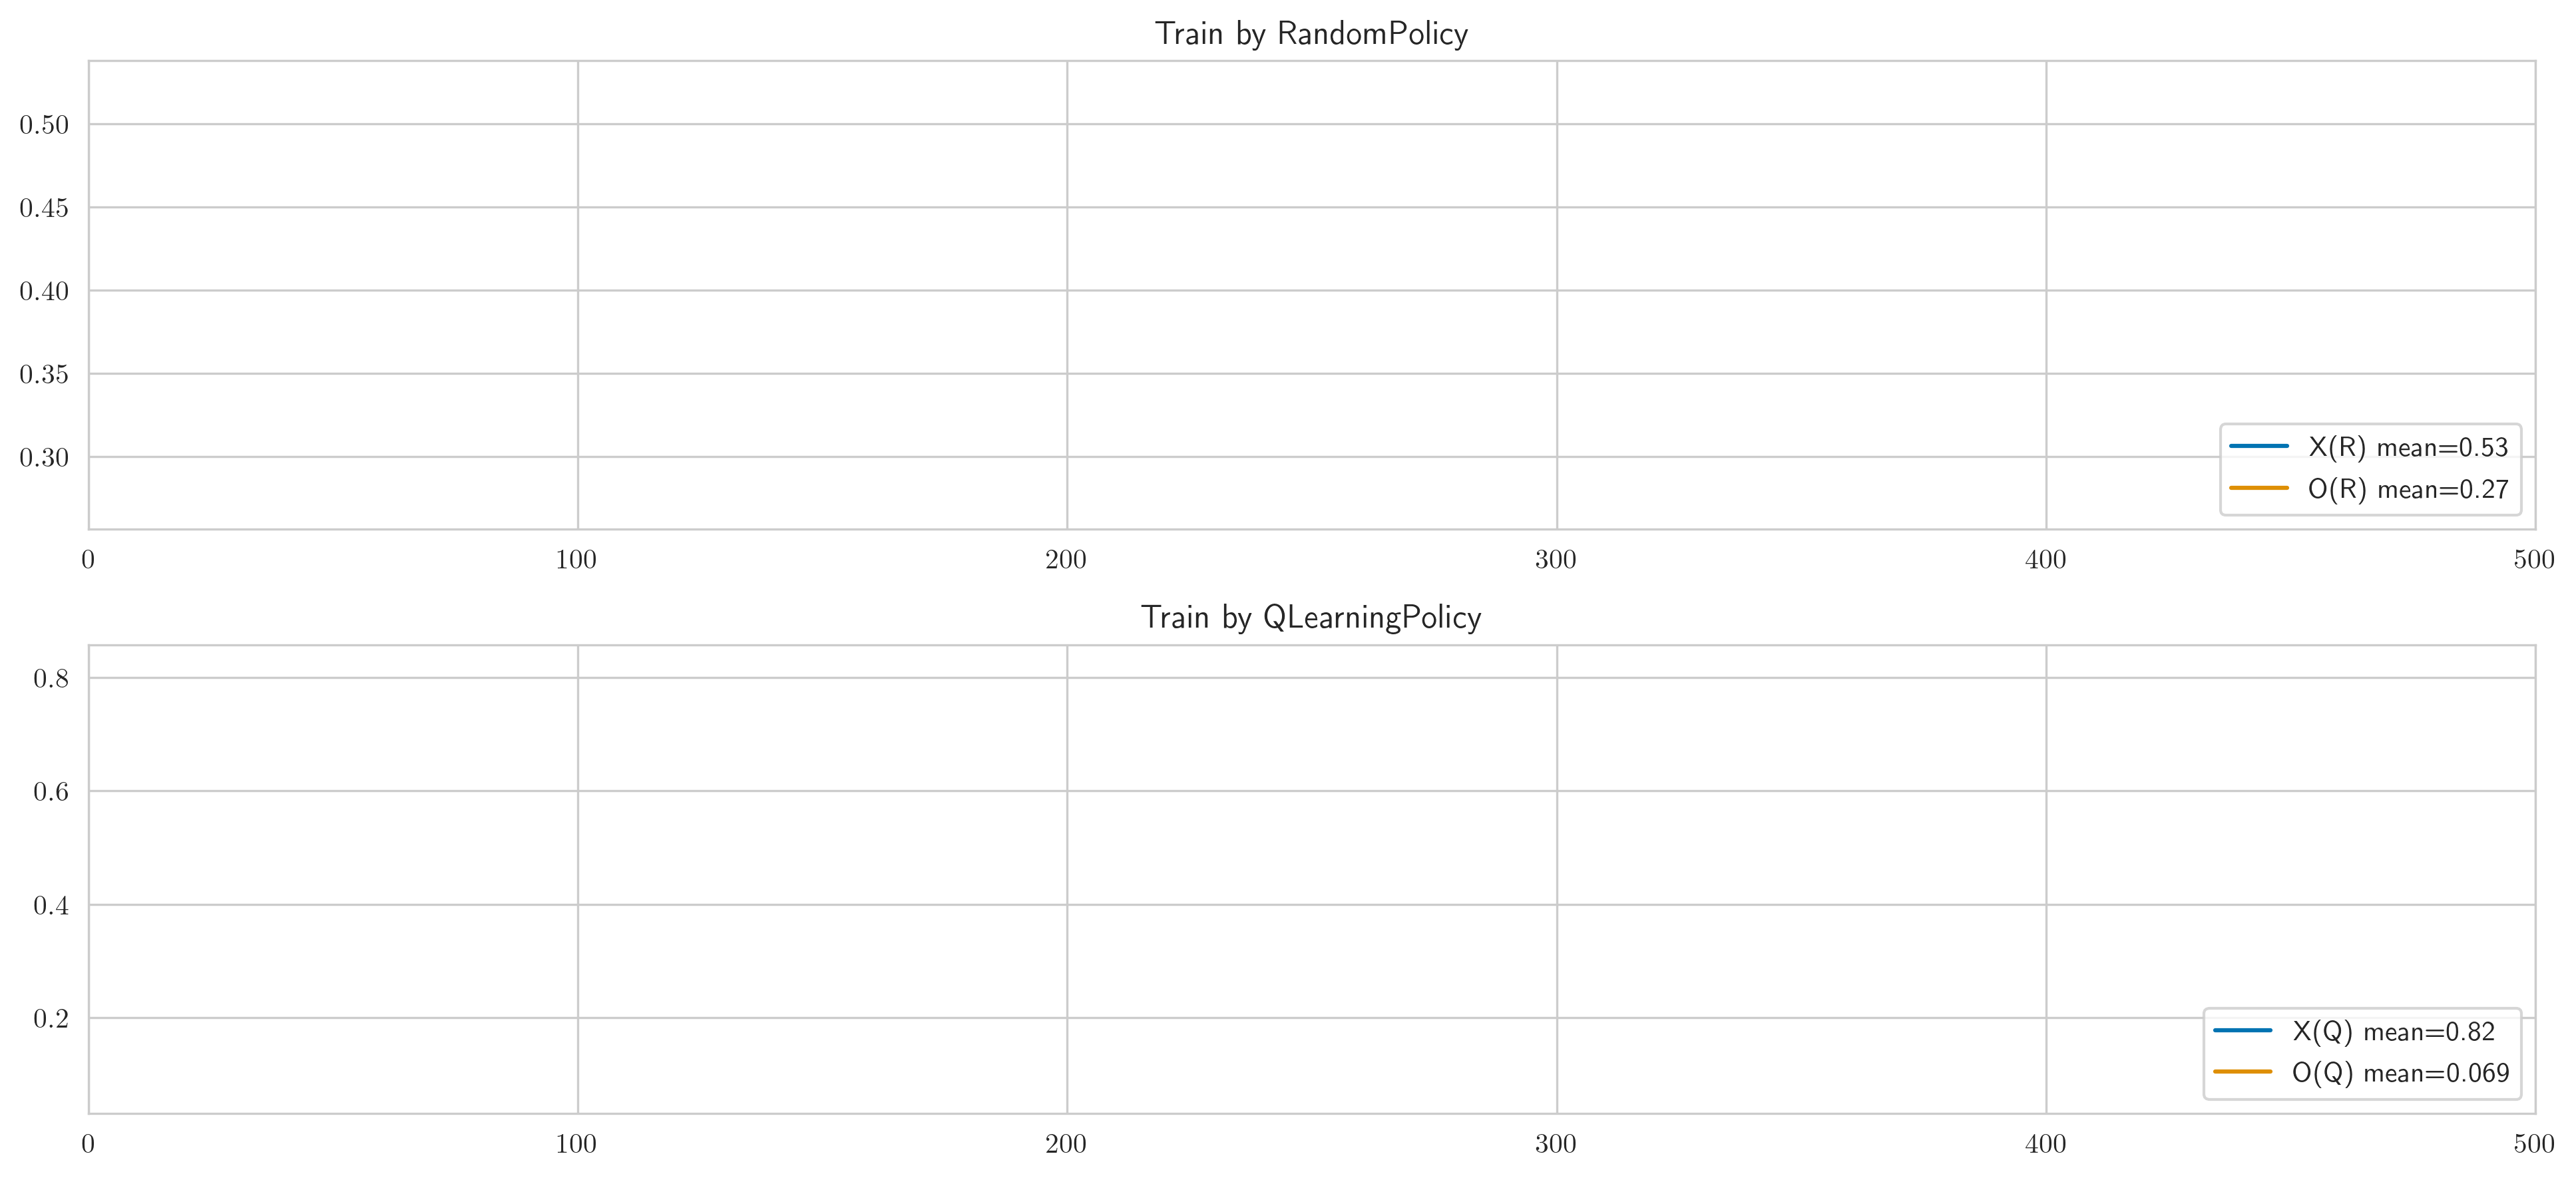

  0%|▏                                          | 2/500 [00:03<14:18,  1.72s/it]

In [ ]:
N_ROWS = 3
N_COLS = 3
N_ITERS = 1000
N_EPOCHS = 500

piXR = QLearningPolicy(name="XR")
piOR = QLearningPolicy(name="OR")
piXQ = QLearningPolicy(name="XQ")
piOQ = QLearningPolicy(name="OQ")

historyXR = []
historyXQ = []
historyOR = []
historyOQ = []

plt.figure(figsize=(13,6))


for epoch in tqdm(range(N_EPOCHS)):
    
    results = run_series(piXR, RandomPolicy(), n_iters=N_ITERS, n_rows=N_ROWS, n_cols=N_COLS)
    historyXR.append(Counter(results)[1] / N_ITERS)

    results = run_series(piXQ, QLearningPolicy(), n_iters=N_ITERS, n_rows=N_ROWS, n_cols=N_COLS)
    historyXQ.append(Counter(results)[1] / N_ITERS)

    results = run_series(RandomPolicy(), piOR, n_iters=N_ITERS, n_rows=N_ROWS, n_cols=N_COLS)
    historyOR.append(Counter(results)[-1] / N_ITERS)

    results = run_series(QLearningPolicy(), piOR, n_iters=N_ITERS, n_rows=N_ROWS, n_cols=N_COLS)
    historyOQ.append(Counter(results)[-1] / N_ITERS)
    
    if epoch % 10 == 0:
        clear_output()
        
        plt.subplot(211)

        plt.plot(historyXR, label=f"X(R) mean={np.mean(historyXR):0.2}")
        plt.plot(historyOR, label=f"O(R) mean={np.mean(historyOR):0.2}")
        # plt.legend(bbox_to_anchor=(1.0, 1.0))
        plt.xlim((0, N_EPOCHS))
        plt.title("Train by RandomPolicy")
        plt.legend(loc="lower right")

        plt.subplot(212)
        plt.plot(historyXQ, label=f"X(Q) mean={np.mean(historyXQ):0.2}")
        plt.plot(historyOQ, label=f"O(Q) mean={np.mean(historyOQ):0.2}")
        plt.xlim((0, N_EPOCHS))
        plt.title("Train by QLearningPolicy")
        plt.legend(loc="lower right")
        
        plt.tight_layout()
        plt.show()



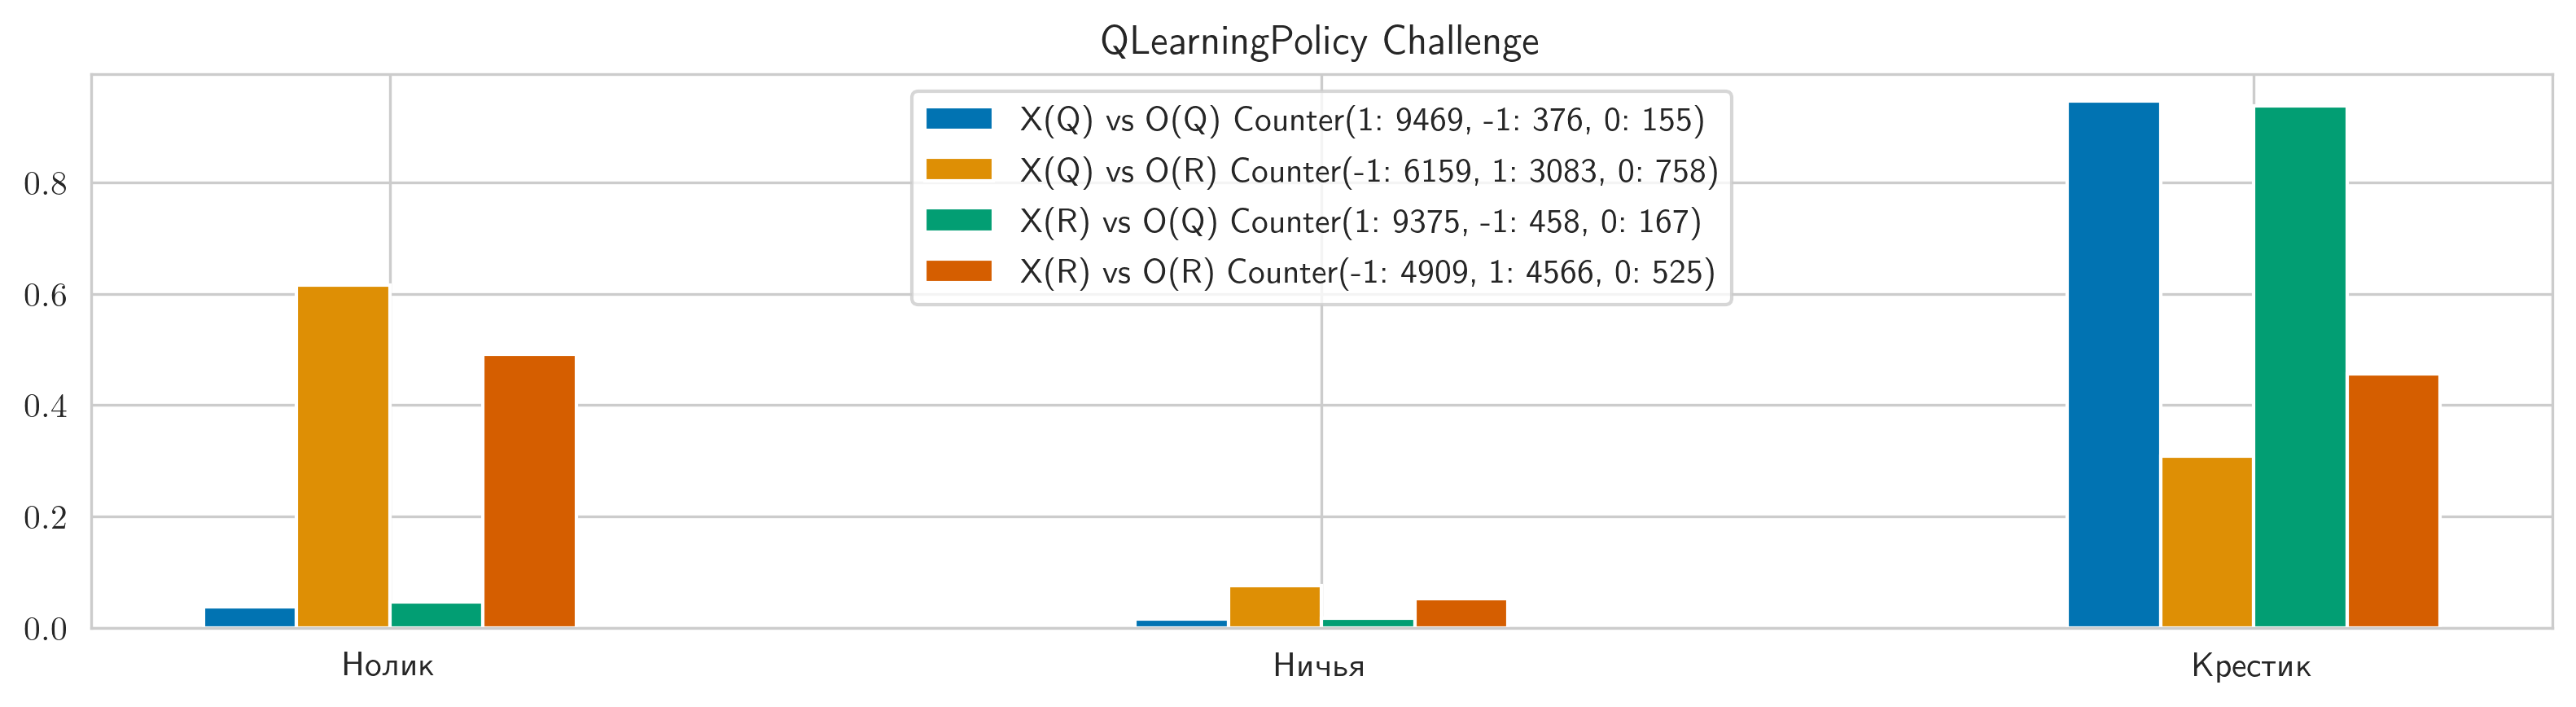

In [10]:
plt.figure(figsize=(13,3))       
witdh = 0.1

results = run_series(piXQ, piOQ)
plot_series_results(results-3/2*witdh, width=witdh, label=f"X(Q) vs O(Q) {Counter(results)}")

results = run_series(piXQ, piOR)
plot_series_results(results-1/2*witdh, width=witdh, label=f"X(Q) vs O(R) {Counter(results)}")

results = run_series(piXR, piOQ)
plot_series_results(results+1/2*witdh, width=witdh, label=f"X(R) vs O(Q) {Counter(results)}")

results = run_series(piXR, piOR)
plot_series_results(results+3/2*witdh, width=witdh, label=f"X(R) vs O(R) {Counter(results)}")

plt.title("QLearningPolicy Challenge")

plt.show()

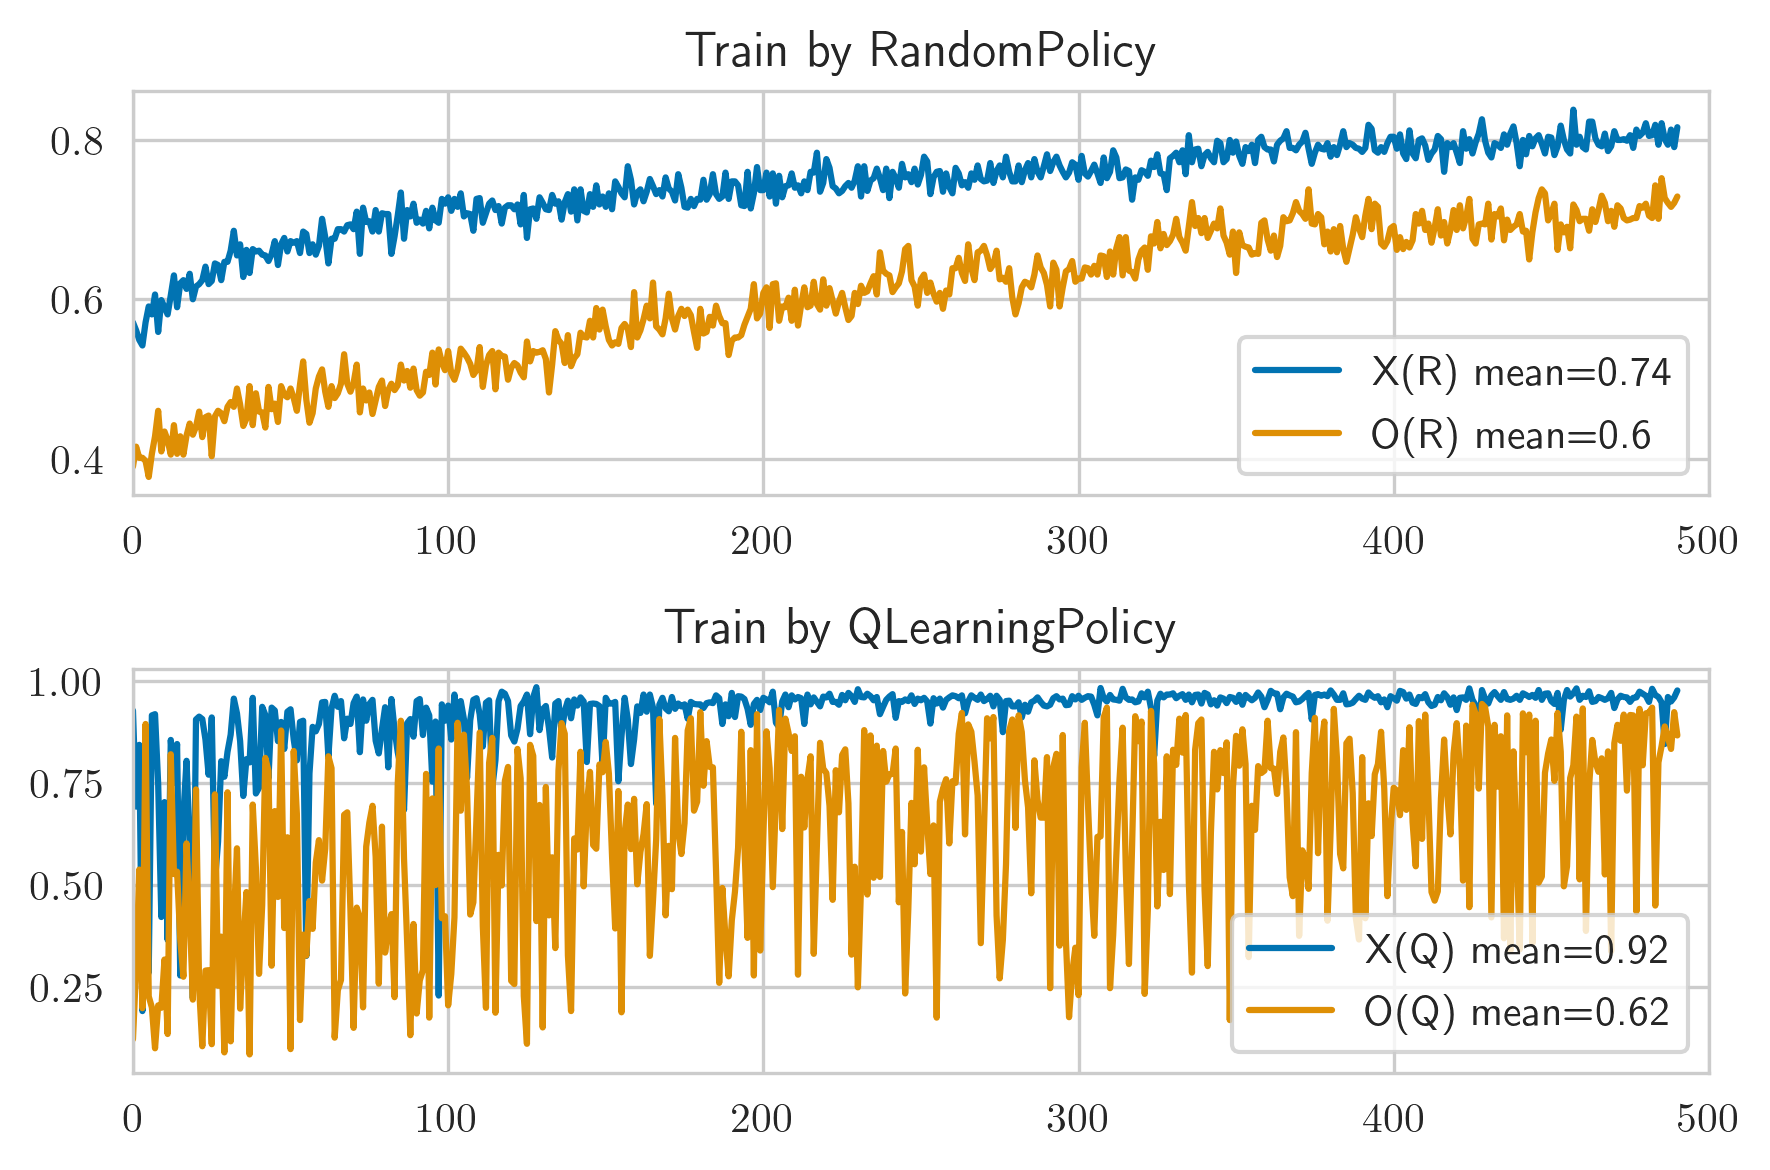

100%|█████████████████████████████████████████| 500/500 [18:30<00:00,  2.22s/it]


In [12]:
N_WIN = 4
N_ROWS = 4
N_COLS = 4
N_ITERS = 1000
N_EPOCHS = 500

piXR = QLearningPolicy(name="XR")
piOR = QLearningPolicy(name="OR")
piXQ = QLearningPolicy(name="XQ")
piOQ = QLearningPolicy(name="OQ")

historyXR = []
historyXQ = []
historyOR = []
historyOQ = []

plt.figure(figsize=(13,6))


for epoch in tqdm(range(N_EPOCHS)):
    
    results = run_series(piXR, RandomPolicy(), n_iters=N_ITERS, n_rows=N_ROWS, n_cols=N_COLS)
    historyXR.append(Counter(results)[1] / N_ITERS)

    results = run_series(piXQ, QLearningPolicy(), n_iters=N_ITERS, n_rows=N_ROWS, n_cols=N_COLS)
    historyXQ.append(Counter(results)[1] / N_ITERS)

    results = run_series(RandomPolicy(), piOR, n_iters=N_ITERS, n_rows=N_ROWS, n_cols=N_COLS)
    historyOR.append(Counter(results)[-1] / N_ITERS)

    results = run_series(QLearningPolicy(), piOR, n_iters=N_ITERS, n_rows=N_ROWS, n_cols=N_COLS)
    historyOQ.append(Counter(results)[-1] / N_ITERS)
    
    if epoch % 10 == 0:
        clear_output()
        
        plt.subplot(211)

        plt.plot(historyXR, label=f"X(R) mean={np.mean(historyXR):0.2}")
        plt.plot(historyOR, label=f"O(R) mean={np.mean(historyOR):0.2}")
        # plt.legend(bbox_to_anchor=(1.0, 1.0))
        plt.xlim((0, N_EPOCHS))
        plt.title("Train by RandomPolicy")
        plt.legend(loc="lower right")

        plt.subplot(212)
        plt.plot(historyXQ, label=f"X(Q) mean={np.mean(historyXQ):0.2}")
        plt.plot(historyOQ, label=f"O(Q) mean={np.mean(historyOQ):0.2}")
        plt.xlim((0, N_EPOCHS))
        plt.title("Train by QLearningPolicy")
        plt.legend(loc="lower right")
        
        plt.tight_layout()
        plt.show()



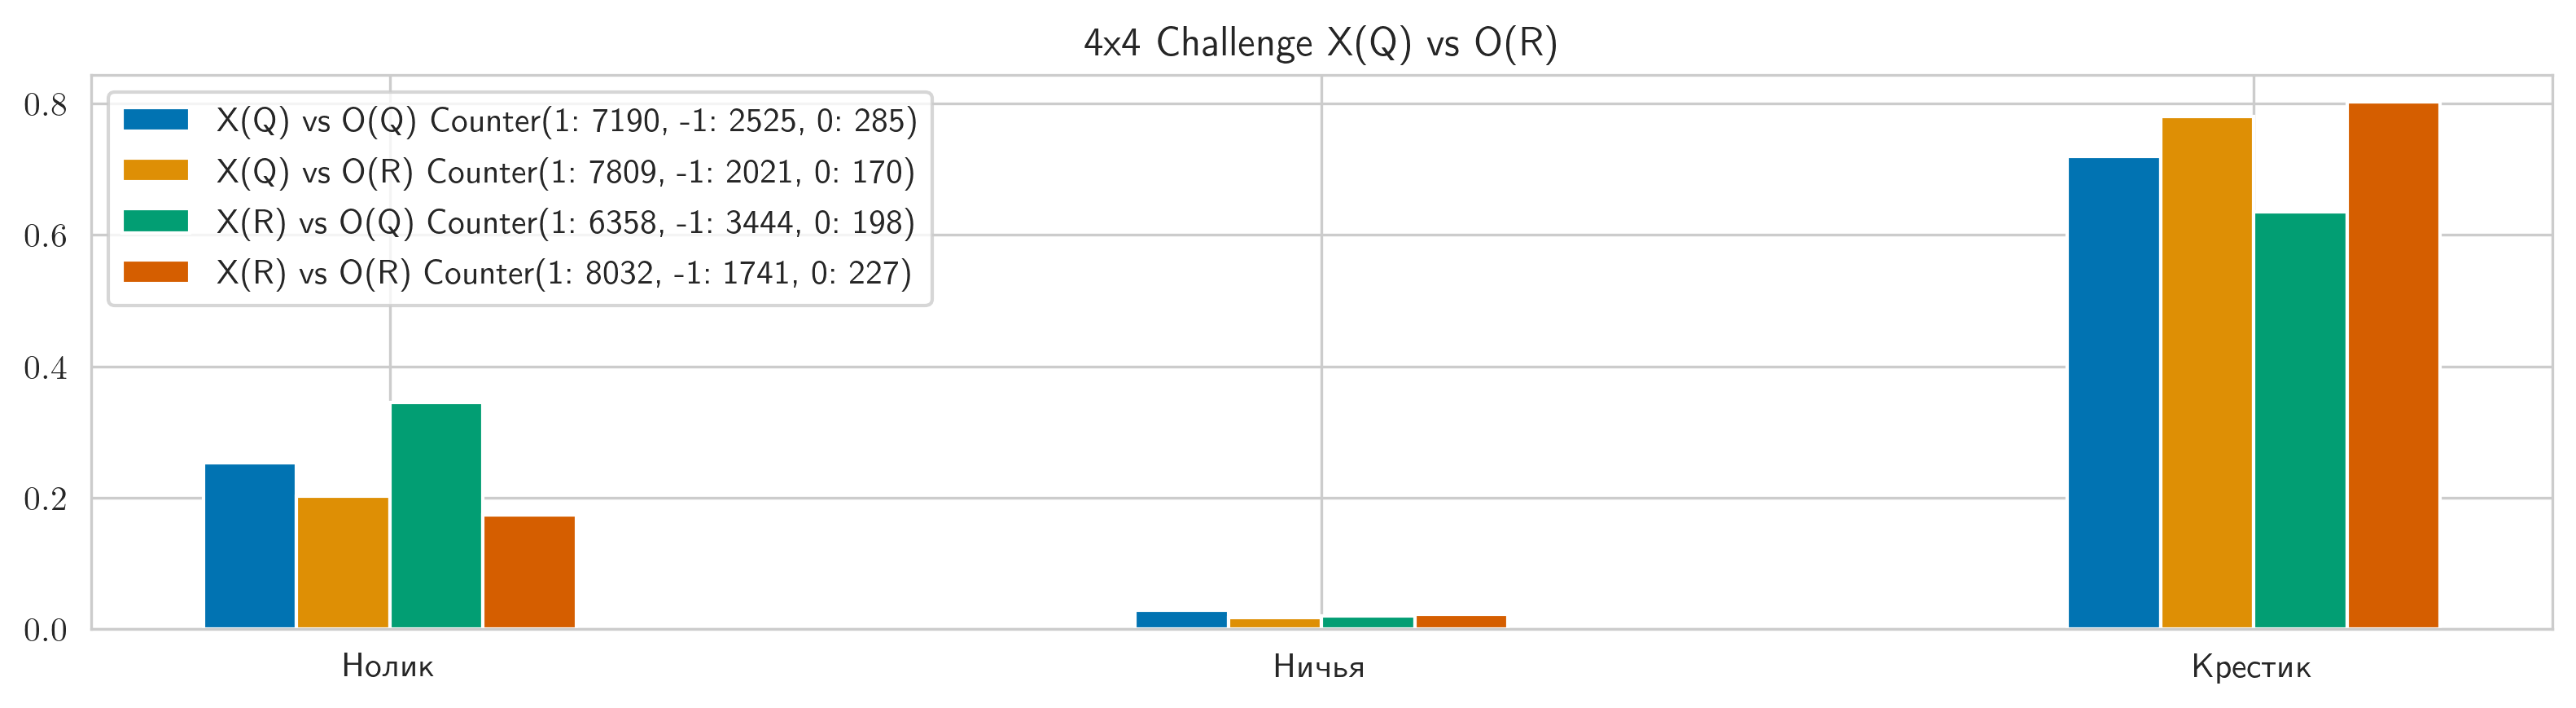

In [13]:
plt.figure(figsize=(13,3))       
witdh = 0.1

results = run_series(piXQ, piOQ)
plot_series_results(results-3/2*witdh, width=witdh, label=f"X(Q) vs O(Q) {Counter(results)}")

results = run_series(piXQ, piOR)
plot_series_results(results-1/2*witdh, width=witdh, label=f"X(Q) vs O(R) {Counter(results)}")

results = run_series(piXR, piOQ)
plot_series_results(results+1/2*witdh, width=witdh, label=f"X(R) vs O(Q) {Counter(results)}")

results = run_series(piXR, piOR)
plot_series_results(results+3/2*witdh, width=witdh, label=f"X(R) vs O(R) {Counter(results)}")

plt.title("4x4 Challenge X(Q) vs O(R)")

plt.show()

# Выводы

- крестик начинает и выигрывает
- крестик учится быстрее
- нолик может научиться хорошо играть даже как обороняющаяся сторона
- обучение на случайных данных более ровное
- крестик лучше обучается на сильном сопернике
- нолик лучше обучается на случайных данных